# 2.1 基于搜索的问题求解

<center><video src="http://files.momodel.cn/search_problem.mp4" controls="controls" width=800px></center>

<br>

现实世界中许多问题都可以通过搜索的方法来求解，例如设计最佳出行路线或是制订合理的课程表。当给定一个待求解问题后，搜索算法会按照事先设定的逻辑来自动寻找符合求解问题的答案，因此一般可将搜索算法称为问题求解智能体。

<img src="http://imgbed.momodel.cn//20200110155424.png" width=500>

<br>

## 2.1.1 搜索算法基本概念

<center><video src="http://files.momodel.cn/search_basic_concept.mp4" controls="controls" width=800px></center>

<br>

我们把书中的公交换乘的问题，转为无向图中的的路径寻找问题。无向图指的是边没有方向的图。

首先，我们画出如下的无向图。该无向图中有 A，B，C，D，E，F，G 七个节点，其中 A 是起点， G 是目标点。

点与点之间的连线称为边，边可以有权重，可以代表点与点之间的距离或者从一个点转移到另一个点需要花费的代价。

下面我们先创建一个图。

In [1]:
# 首先导入必要的包
from search import Graph
import collections
import matplotlib.pyplot as plt
import collections
from IPython import display
import networkx as nx
import numpy as np
import time

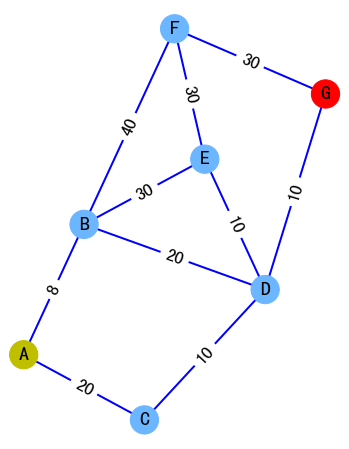

In [5]:
# 定义节点列表
node_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# 定义边及权重列表
weighted_edges_list = [('A', 'B', 8), ('A', 'C', 20),
                       ('B', 'F', 40), ('B', 'E', 30),
                       ('B', 'D', 20), ('C', 'D', 10), 
                       ('D', 'G', 10), ('D', 'E', 10),
                       ('E', 'F', 30), ('F', 'G', 30)]
# 定义绘图中各个节点的坐标
nodes_pos = {"A": (1, 1), "B": (3, 3), "C": (5, 0), "D": (9, 2),
             "E": (7, 4), "F": (6,6),"G": (11,5)}

# 实例化图
g = Graph()
g.add_nodes_from(node_list)
g.add_weighted_edges_from(weighted_edges_list)
g.set_nodes_pos(nodes_pos)

# 设置起点
g.set_start_node('A')
# 设置目标点
g.set_target_node("G")
# 设置最大搜索深度
g.set_max_depth(3)

g.show_graph()

观察上图，可以看到从起点 A 到目标点 G 距离最短的路径是 A -> B -> D  -> G，其距离是 38，我们可以设计一个计算机程序，按照既定的规则，从起点 A 出发，不断尝试从一个节点移动到下一个节点，直到抵达目标点 G。

<br>

在详细描述搜索算法之前，先看看下面四个重要的概念。

+ **状态**。状态可以认为是搜索算法在某一时刻所处的位置，相应地，搜索算法在开始和结束时所处的位置成为**初始状态**和**终止状态**。

+ **测试目标**。用于判断当前状态是不是目标状态。例如在此问题中目标点是 G，因此目标测试只需要判断当前状态是否为 G 即可。当然，即使到达了目标状态，找到路径也未必是代价最小的。

+ **动作**。动作指的是搜索算法从一个状态转变到另外一个状态所采取的行为。一般假设在每个状态下所能够采取的行为数量都是有限的。例如：在起点 A，只有 B 和 C 两个节点与之相连，所以只有转移到 B 或者转移到 C 这两种选择。一般情况从一个状态到另外一个状态的过程叫做**状态转移**。

+ **路径**。完成一系列连续的状态转移所得到的状态序列，就构成了从起点到终点的路径，如从状态 A 到状态 B，接着到状态 D，最后到状态 G，就形成了A -> B -> D  -> G 这样的一条路径。很显然，路径的总代价，等于路径上各个节点之间代价的总和。在路径搜索问题中，任何一条路径的代价都不会是负数。



看下图，理解上面的四个概念。

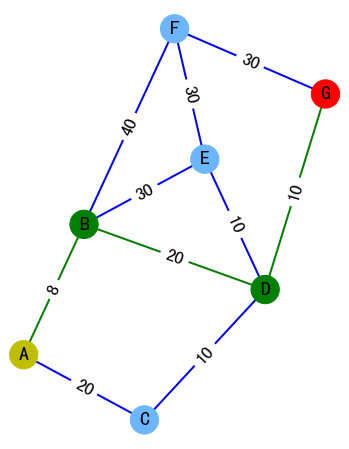

In [6]:
g.show_graph(this_path="ABDG")

<br>

## 2.1.2 搜索算法

<center><video src="http://files.momodel.cn/search_tree.mp4" controls="controls" width=800px></center>

<br>

搜索算法就是不断从某一状态转移到下一状态，直至到达终止状态为止。


在搜索算法中，从当前状态出发寻找后续节点，一般会面临多种选择。比如上例中，从 A 出发，可以选择 B 或者 C；从 B 出发，可以选择 A、D、E 或者 F；从 C 出发，可以选择 A 或 D，可见状态之间这种转移构成的如下图的分层树状结构，该结构称为**搜索树**。

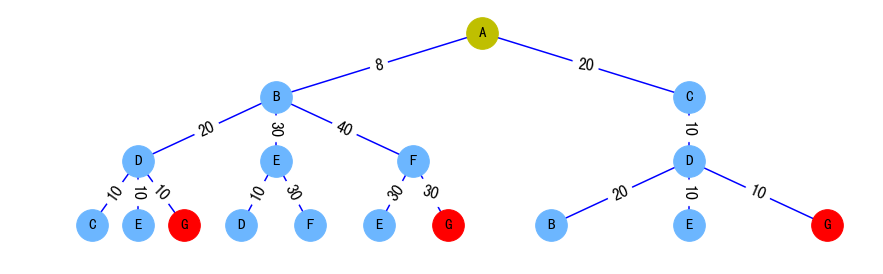

In [7]:
g.show_search_tree()

<br>

在搜索树中，每个结点可用一个状态来标记，表示从根节点出发，经过怎样的路径到达该节点，两个节点之间的连线表示这两个节点之间存在状态转移。搜索树状态中，由于每个结点这种状态来标记，因此可能存在两个拥有相同标记的节点，但其含义不同。

*注意：路径搜索不能出现回路。*

搜索算法从初始节点出发，不断选择后续节点，完成了搜索树的构造。一开始，搜索树中只有根节点，在每一步中搜索算法将选择与搜索树中某个节点相邻的一个后续节点加入搜索树，这个操作叫做**扩展一个节点**。

能够扩展的节点需满足条件：
+ 该节点不能已经在搜索树中，即该节点不能已经被扩展过；
+ 该节点能够从搜索树中某个节点出花通过执行一个动作抵达，被扩展节点和搜索树节点的某个节点是相邻的。  

这些能够被扩展的节点构成的集合称为**未访问节点集合**。

于是，搜索算法的每一步操作可以做如下描述：  
每次选择未访问节点集合中的一个节点加入当前搜索树，检查这个节点所有后续相邻节点，将满足条件的节点加入未访问节点集合中，重复执行上述操作，直至被扩展的节点对应一条从初始节点到终止结点的路径。

<br>

## 2.1.3 深度优先搜索和广度优先搜索

<center><video src="http://files.momodel.cn/search_dfs_bfs.mp4" controls="controls" width=800px></center>

<br>

<img src="http://imgbed.momodel.cn//20200110151426.png" width=600>

**深度优先搜索**总是沿着某个分支进行搜索、直至不能再深入为止，即优先扩展搜索树当前未访问节点集合中最深的节点。深度优先搜索算法在搜索过程中总是倾向于沿着一条分支前进，直到该分支上所有的节点都被访问完，再返回上一层进行另一轮深度优先搜索。

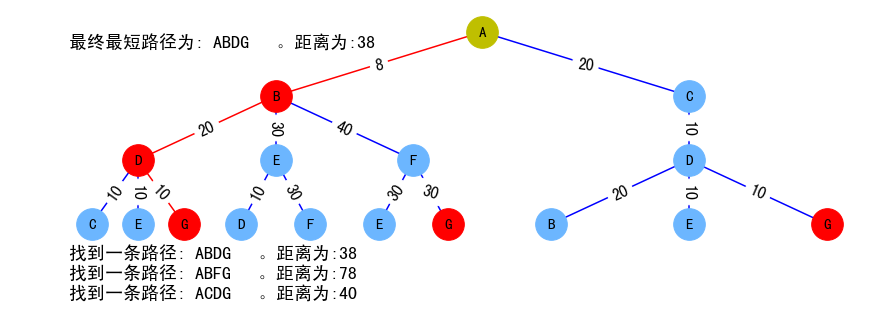

In [9]:
g.animate_search_tree('dfs')

**广度优先搜索**总是优先扩展为访问节点集合中最浅的节点，在执行中倾向于优先把同一层的所有可能节点访问完后再考虑进行更深的探索。

<br>

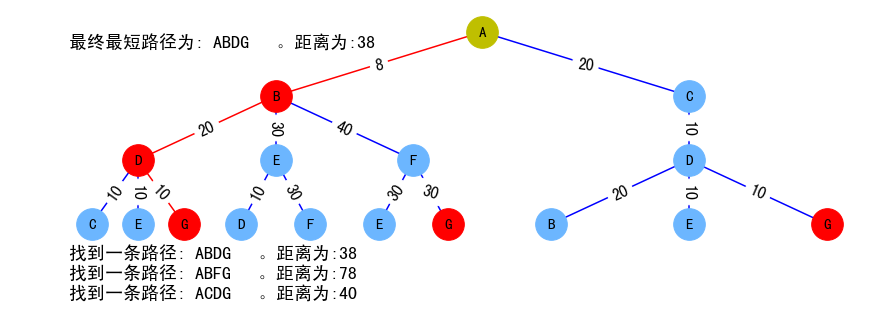

In [10]:
g.animate_search_tree('bfs')

需要强调的是，对于一个搜索问题，只要存在答案（即从初始节点到终止节点存在满足条件的一条路径），那么排除了回路的深度优先搜索和广度优先搜索均能找到一个答案，但是这个找到的答案不一定是最优的，例如距离最短。

<br>

### 扩展内容
** 深度优先搜索 dfs ** 基础代码解读

```
def iter_dfs(G, start, target):
    '''
    深度优先搜索
    :param G: 字典，存储每个点的相邻点
    :param start: 初始点
    :param target: 目标点
    :return:
    '''

    # 定义已访问的点的集合
    S = set()
    # 定义一个待访问点的列表
    Q = []
    # 把初始点放进列表中
    Q.append(start)
    while Q:
        # 只要带访问的列表不为空，那么从列表中拿取最后一个元素，也就是一个点，记作 u
        u = Q.pop()
        # 如果当前点是目标点，则结束查找
        if u == target:
            break
        # 如果该点已经被访问了，则跳过此点
        if u in S:
            continue
        # 访问此点，将点加入已访问点的结合 S 中
        S.add(u)
        # 将点 u 相邻的点放入待访问的列表中
        Q.extend(G[u])
```

<br>

## 2.1.4 启发式搜索

<center><video src="http://files.momodel.cn/search_greedy.mp4" controls="controls" width=800px></center>

<br>

在搜索过程中利用问题的定义以外**辅助信息**的搜索算法称为**启发式搜索算法**，或者叫**有信息的搜索算法**。

在路径搜索问题中，可引入任意一个节点与目标节点之间的直线距离，作为辅助信息，来提升搜索算法的效率。根据这一想法，可以设计一个直观的最短路径搜索算法：算法从初始节点开始，每一步都将未访问节点集合中离目标节点直线距离最近的节点加入搜索树，直至到达目标站点，这个算法称为**贪婪最佳优先搜索**。

**辅助信息：各个节点到目标节点G的直线距离**

|站点|A|B|C|D|E|F|G|
|--|--|--|--|--|--|--|--|
|距离|30|20|19|10|5|25|0|

贪婪最佳优先算法搜索过程如下：

In [ ]:
# 为搜索算法提供辅助信息
g.help_info = {'A': 30, 'B': 20, 'C': 19, 'D':10, 'E':5, 'F':25, 'G': 0}
# 动态演示贪婪搜索
g.animation_search_tree('greedy')

<br>

但是在“贪婪”机制下找到的路径 A -> C -> D -> G 并非最短路径。产生这样的搜索结果，其原因是：最佳优先算法在当前节点时，每次均贪婪的从当前节点相邻的节点中选择**与目标节点直线距离最近的节点**，作为后续节点。这样就会造成贪婪最佳优先算法**过于重视当前的最优，而忽视了全局最优**。


另一种启发式搜索算法—— A\* 算法克服了这一不足。

<center><video src="http://files.momodel.cn/search_a_star.mp4" controls="controls" width=800px></center>

<br>

其算法思路是：将初始节点到目标节点的距离分成两部分，
- 初始节点到当前节点的路径代价；
- 当前节点到目标节点之间的直线距离。将两者之和作为评价函数的取值大小。

具体而言，对于未访问节点集合中某个节点 n，A\* 算法评价节点 n 取值大小的评价函数 f(n) 由两部分构成：
+ 函数 g(n): 表示从初始节点到当前节点 n 的实际距离，
+ 函数 h(n): 表示当前节点 n 到目标节点的直线距离。函数 h(n) 也称为**启发函数**。


 A\* 算法搜索过程：

In [ ]:
# 为搜索算法提供辅助信息
g.help_info = {'A': 30, 'B': 20, 'C': 19, 'D':10, 'E':5, 'F':25, 'G': 0}
# 动态演示 A* 算法
g.animation_search_tree('a_star')

<br>

In [ ]:
# 可以调整辅助信息的比重
# 当只考虑额外信息时，即 origin_info_weight 设置为 0 的时候，A* 算法退化为贪婪算法。
g.animation_search_tree('a_star',help_info_weight=1, origin_info_weight=0)

与贪婪最佳优先算法不一定能够找到最短路径不同，A\* 算法找到的路径一定是最短路径；另一方面，由于A\* 算法能够利用辅助信息，因此它比其他算法用更少的步骤。

在实际中，A\* 算法的性能表现取决于启发函数的设计，只要定义一个合适的启发函数，A\* 算法就能够大幅缩减搜索所需的时间。

<br>

####  思考与练习

下图是一张线路示意图。

In [ ]:
node_list = ["0","1","2","3","4"]
weighted_edges_list = [("0","1",10), ("0","2",10),
                       ("1", "3", 10), ("2", "3", 5),
                       ("2", "4", 20), ("3", "4", 14),
                       ("3", "2", 5)]
nodes_pos = {"0":(1,7),"1":(5,1),"2":(5,13),"3":(9,7),"4":(11,13)}
h_graph = SearchGraph(node_list, weighted_edges_list, "0", "4", 3, nodes_pos)
h_graph.show_graph()


如果使用深度优先搜索求状态 0 到状态 4 的一条路径，我们可以用下表来模拟搜索过程。注意：在下表中，结点的深度定义为它对应路径中状态转移的次数，如果多个未访问结点的深度相同，那么在这个例子里算法优先选择状态编号大的节点。

|步骤|当前状态|当前未访问节点集合(用上划线标出了下一个扩展的节点)|
|:--:|:--:|:--|
|1|0|深度1：${0 -> 1,\overline{0 -> 2}}$|
|2|2|深度1：${0 -> 1}$ 深度2：$\underline{（1）}$|
|3|$\underline{（2）}$|找到路径：0 -> 2 -> 4|

请仔细观察上表中各项内容的含义，根据深度优先搜素的思路，在横线（1）和（2）处填写内容。问找到的路径0->2->4是代价最小的吗？

答案 1：

(1)$2->3,\overline{2->4}$  
(2)4  

答案 2：

不是，代价最小为29，其路径为：0->2->3->4。 

In [ ]:
# 查看 dfs 的搜索过程
h_graph.animation_search_tree('dfs')

<br>

## 扩展阅读
1. [Introduction to the A* Algorithm](https://www.redblobgames.com/pathfinding/a-star/introduction.html)
2. [游戏开发中的人工智能：A* 路径寻找算法](https://blog.csdn.net/Jurbo/article/details/75532885)
3. [A* Search Algorithm](https://www.101computing.net/a-star-search-algorithm/)
4. [A star Pathfinding A星寻路算法](https://www.bilibili.com/video/av32847834/)
 